##### (common setup stuff)

In [1]:
%%bash
[[ ! -d 'index-robust04' ]] && {
echo "Downloading robust04 index"
wget -q https://git.uwaterloo.ca/jimmylin/anserini-indexes/raw/master/index-robust04-20191213.tar.gz
tar xzf index-robust04-20191213.tar.gz
mv index-robust04-20191213 index-robust04
} || echo "robust04 index already downloaded."

robust04 index already downloaded.


In [2]:
%%bash
[[ ! -d 'jdk-11' ]] && {
echo "Downloading jdk 11 for pyserini"
wget -q https://download.java.net/java/ga/jdk11/openjdk-11_linux-x64_bin.tar.gz
tar xzf openjdk-11_linux-x64_bin.tar.gz
( cd jdk-11 && ln -vs . jre )
( cd jdk-11/lib && ln -vs . amd64 )
} || echo "jdk 11 already downloaded."

jdk 11 already downloaded.


In [305]:
from IPython.display import display, HTML, Image

In [4]:
import os
_jhome = os.environ['JAVA_HOME']
os.environ['JAVA_HOME'] = f'{os.getcwd()}/jdk-11'
from pyserini.search import SimpleSearcher
robust04 = SimpleSearcher('index-robust04')
os.environ['JAVA_HOME'] = _jhome

from bs4 import BeautifulSoup
def fetch_bs4_doc(docid):
    d = robust04.doc(docid)
    bs = BeautifulSoup(d.raw(), features='html.parser') if d else None
    return bs

def fetch_elems(docid, *elems):
    bs = fetch_bs4_doc(docid)
    entries = (bs.findChild(e) if bs else 'NO_SUCH_DOC' for e in elems)
    return tuple('NO_SUCH_FIELD' if e is None else (e.text.strip() if hasattr(e, 'text') else e) for e in entries)

fetch_headline = lambda docid: fetch_elems(docid, 'headline')[0]
fetch_text = lambda docid: fetch_elems(docid, 'text')[0]
fetch_doc = lambda docid: fetch_elems(docid, 'headline', 'text')


In [5]:
%run -i experiments_common.py

In [6]:
%%time
#os.environ['PYSPARK_PYTHON'] = 'python3.6'
#os.environ['HADOOP_CONF_DIR'] = os.path.join(os.environ['HOME'], 'aitools4-aq-cluster-computing/conf/hadoop')



sparkconf = SparkConf()

n_exc = 160
cores = 16

mode = 'yarn'

if mode == 'yarn':
    (sparkconf.setMaster('yarn')
      .set('spark.driver.memory', '32g')
      .set('spark.driver.maxResultSize', '2g')
      .set('spark.executor.memory', '64g')
     .set('spark.executor.cores', str(cores))
     .set('spark.executor.instances', str(n_exc))
     .set('spark.default.parallelism', str(n_exc*cores))
    )
elif mode == 'standalone':
    (sparkconf.setMaster('spark://betaweb020.medien.uni-weimar.de:7077')
      .set('spark.driver.memory', '32g')
      .set('spark.driver.maxResultSize', '2g')
     .set('spark.default.parallelism', str(129*12))
    )
                    
global spark

if 'spark' in globals() and hasattr(spark, 'stop'):
    spark.stop()
    SparkSession._instantiatedContext = None
    
spark = SparkSession.builder.config(conf=sparkconf).getOrCreate()

spark


CPU times: user 47.8 ms, sys: 48.9 ms, total: 96.7 ms
Wall time: 40 s


In [26]:
%%time
dataset_path = 'axexp/prefs/2019-05-01_uniform-samples_21-axioms.jsonl'
dataset_sparkdf = spark.read.json(dataset_path)
col_predictors = [x for x in dataset_sparkdf.columns if x.startswith('ax_')]
col_response = 'concordant'

CPU times: user 12.9 ms, sys: 578 µs, total: 13.5 ms
Wall time: 7.78 s


In [27]:
# classifier template
make_classifier = lambda: sklearn.ensemble.RandomForestClassifier(max_depth=20, n_estimators=128)

serialize_model = lambda m: base64.b64encode(pickle.dumps(m))
deserialize_model = lambda b64: pickle.loads(base64.b64decode(b64))

In [28]:
ndcgs = pd.read_table('./../robust04/ncdg-systems.tsv', header=None, names=['system', 'query', 'ndcg'])

topics=!grep -A3 '<num>' ../robust04/topics.robust04.301-450.601-700.txt | sed 's/<num>.*: //;s/<title> //' 

topics = [[y.strip() for y in x.strip().split('\n') if y and y != '<title>'][:2] for x in
 '\n'.join(topics).split('--')
]

topics = dict((int(qid), q) for qid, q in topics)

In [7]:
%%time
# additional info on concordant/discordant pairs / bm25 rankings, etc
all_concordant_pairs = spark.read.json('/user/kibi9872/axexp/explorative-analysis-in-progress/robust-04-uniform-samples-21-axioms-2019-05-01.jsonl').toPandas()

all_concordant_pairs['qid'] = all_concordant_pairs['query'].astype('int')

all_concordant_pairs['lower_rank'] = all_concordant_pairs.upper_rank - all_concordant_pairs.rankdiff
all_concordant_pairs['lower_score'] = all_concordant_pairs.upper_score + all_concordant_pairs.scorediff

In [8]:
qrels = pd.read_table('../robust04/qrels.robust2004.txt', sep=' ', names=['qid', 'q0', 'docid', 'relevance'])
qrels = qrels.set_index(['qid', 'docid'])['relevance']

all_rankings = None
for system in ['bm25', 'drmm', 'pacrr_drmm', 'mp_cos']:
    fn = f'../robust04/runs/topics.robust04/all_topics.top1000.{system}.txt'
    sniff = next(open(fn))
    cols = ['qid', 'q0', 'docid', 'rank', 'score', 'system', 'x'][:len(sniff.split())]
    df = pd.read_table(fn, sep='\t' if '\t' in sniff else ' ', names=cols)
    df['system'] = df.system.str.upper()
    df = df.join(qrels, on=['qid', 'docid'])
    df['relevance'] = df.relevance.astype('Int64')
    df = df.set_index(['system', 'qid', 'rank'])[['docid', 'score', 'relevance']]
    if all_rankings is None:
        all_rankings = df
    else:
        all_rankings = pd.concat([all_rankings, df])
all_rankings

docid      score  relevance
system qid rank                                   
BM25   301 1      CR93E-9750  13.031700       <NA>
           2     FBIS4-40260  12.849700          0
           3     FBIS4-46734  12.840900          0
           4     FBIS3-24145  12.831600          0
           5     FBIS4-39330  12.794200          0
...                      ...        ...        ...
MP-COS 689 995   FBIS3-48790   0.833261          0
           996   FBIS4-26117   0.769795          0
           997    FT933-2666   0.741941       <NA>
           998    FT932-5393   0.631475       <NA>
           999   FT932-12604   0.323854       <NA>

[538884 rows x 3 columns]

In [29]:
all_concordant_pairs.query('qid==301 & system=="DRMM" & upper_rank < 4 & lower_rank < 5').sort_values('upper_rank').drop(columns=col_predictors)

,bm25_preference_opposite,concordant,id1,id1_pos_in_bm25,id1_relevance,id1_score,id2,id2_pos_in_bm25,id2_relevance,id2_score,qrel_preference,query,rankdiff,scorediff,system,upper_rank,upper_score,qid,lower_rank,lower_score
1415451,False,1,FBIS4-26192,None,0,0,FBIS3-21961,17,1,0,wrong,301,1,0.007628,DRMM,1,8.446608,301,0,8.454236
393412,False,1,FBIS4-26192,None,0,0,FBIS3-19646,16,1,0,wrong,301,2,0.044504,DRMM,2,8.409732,301,0,8.454236
677502,True,1,FBIS3-21961,17,1,0,FBIS3-19646,16,1,0,correct,301,1,0.036876,DRMM,2,8.409732,301,1,8.446608
787025,False,1,FBIS3-21961,17,1,0,FBIS4-68087,145,None,0,None,301,2,0.038183,DRMM,3,8.408425,301,1,8.446608
1038632,False,1,FBIS3-19646,16,1,0,FBIS4-68087,145,None,0,None,301,1,0.001307,DRMM,3,8.408425,301,2,8.409732
1254387,False,1,FBIS4-26192,None,0,0,FBIS4-68087,145,None,0,None,301,3,0.045811,DRMM,3,8.408425,301,0,8.454236


In [30]:
dataset_sparkdf.printSchema()

root
 |-- ax_AND: long (nullable = true)
 |-- ax_DIV: long (nullable = true)
 |-- ax_LB1: long (nullable = true)
 |-- ax_LNC1: long (nullable = true)
 |-- ax_M_AND: long (nullable = true)
 |-- ax_M_TDC: long (nullable = true)
 |-- ax_PROX1: long (nullable = true)
 |-- ax_PROX2: long (nullable = true)
 |-- ax_PROX3: long (nullable = true)
 |-- ax_PROX4: long (nullable = true)
 |-- ax_PROX5: long (nullable = true)
 |-- ax_REG: long (nullable = true)
 |-- ax_STMC1: long (nullable = true)
 |-- ax_STMC1_f: long (nullable = true)
 |-- ax_STMC1_fr: long (nullable = true)
 |-- ax_STMC2: long (nullable = true)
 |-- ax_STMC2_f: long (nullable = true)
 |-- ax_STMC2_fr: long (nullable = true)
 |-- ax_TFC1: long (nullable = true)
 |-- ax_TFC3: long (nullable = true)
 |-- ax_TF_LNC: long (nullable = true)
 |-- concordant: long (nullable = true)
 |-- query: string (nullable = true)
 |-- rankdiff: long (nullable = true)
 |-- scorediff: double (nullable = true)
 |-- system: string (nullable = true)
 |-

In [31]:
def mk_fit_fn(group_key, keep_model=False, features=list(col_predictors), num_cv_folds=10):
    
    output_schema = [
        T.StructField(fn, T.StringType(), False) for fn in group_key
    ] + [
        T.StructField('cv_accuracy_mean', T.FloatType(), False),
        T.StructField('cv_accuracy_std', T.FloatType(), False),
        T.StructField('avg_train_samples_per_fold', T.FloatType(), False),
        T.StructField('avg_test_samples_per_fold', T.FloatType(), False),
        T.StructField('feature_importances', T.ArrayType(T.FloatType(), False))
    ]
    
    
    
    if keep_model:
        output_schema.append(T.StructField('model', T.StringType(), False))    
    
    output_schema = T.StructType(output_schema)
    
    
    @pandas_udf(output_schema, PandasUDFType.GROUPED_MAP)
    def fit(pdf):
        """Fit a sub-model on a partial dataframe while recording CV scores."""
        import os
        os.environ['ARROW_PRE_0_15_IPC_FORMAT'] = '1'
        xs = pdf[features].values
        ys = pdf[col_response]
        group = list(pdf[group_key].iloc[0])
        columns = group_key + ['cv_accuracy_mean', 'cv_accuracy_std', 'avg_train_samples_per_fold', 'avg_test_samples_per_fold', 'feature_importances']

        if keep_model:
            columns.append('model')
        
        clf = make_classifier()
        #scores = cross_val_score(clf, xs, ys, cv=num_cv_folds)

        splits = GroupShuffleSplit(n_splits=num_cv_folds, random_state=0, test_size=(1/num_cv_folds))
        split_groups = pdf.upper_rank.map(str) + '-' + pdf.rankdiff.map(str)
        scores = cross_val_score(clf, xs, ys, cv=splits.split(xs, ys, split_groups))
        sample_sizes = np.array([[len(tr), len(ts)] for tr, ts in splits.split(xs, ys, split_groups)])
        avg_ntr, avg_nts = sample_sizes.mean(axis=0)

        full_model = clf.fit(xs, ys)
        fimps = pd.Series(data=full_model.feature_importances_, index=features)
        out =  pd.DataFrame([
            group + [scores.mean(), scores.std(), avg_ntr, avg_nts, fimps] + ([serialize_model(full_model)] if keep_model else []) ],
            columns=columns
        )

        return out
    return fit

def feature_importances(df, group_key, features=list(col_predictors)):
    s = df.feature_importances.map(lambda a: dict(zip(features, a)))
    s = pd.DataFrame(list(s))
    s = pd.concat([df, s], axis=1)
    s = s.melt(id_vars=group_key, value_vars=features, var_name='feature', value_name='importance')
    s['feature'] = s.feature.map(lambda fname: fname.replace('ax_', ''))
    return s
    

# Query-local fidelity model

Split training data by (query, system) -- i.e. for each system, train one model per query.

In [32]:
%%time
df = dataset_sparkdf
#df = df[(df.query == '356') & (df.system == 'DRMM')]
query_system = ['query', 'system']
fit = mk_fit_fn(group_key=query_system, keep_model=False)
query_local_stats = df.groupBy(query_system).apply(fit).toPandas()

CPU times: user 144 ms, sys: 60.4 ms, total: 204 ms
Wall time: 1min 8s


In [33]:
a = query_local_stats
a['query'] = a['query'].map(int)
a = a.set_index(['system', 'query'])
b = ndcgs.set_index(['system', 'query'])
j = a.join(b, how='inner', sort=True).reset_index()
for i, ax in enumerate(col_predictors):
    j[ax] = j['feature_importances'].map(lambda arr: arr[i])

j = j.reset_index()
j['qwords'] = j['query'].map(lambda q: len(topics[q].split()))
j['qchars'] = j['query'].map(lambda q: len(topics[q]))
j['fidelity'] = j['cv_accuracy_mean'] # alias

query_local_stats = j

In [34]:
query_local_stats.head(3)

,index,system,query,cv_accuracy_mean,cv_accuracy_std,avg_train_samples_per_fold,avg_test_samples_per_fold,feature_importances,ndcg,ax_AND,...,ax_STMC1_fr,ax_STMC2,ax_STMC2_f,ax_STMC2_fr,ax_TFC1,ax_TFC3,ax_TF_LNC,qwords,qchars,fidelity
0,0,DRMM,301,0.597358,0.018291,9192.0,1022.0,"[0.0, 0.0778839960694313, 0.08819776028394699,...",0.1554,0.0,...,0.017329,0.024039,0.023899,0.025065,0.081490,0.000000,0.010178,3,29,0.597358
1,1,DRMM,303,0.708415,0.020262,9192.0,1022.0,"[0.0, 0.10673416405916214, 0.06915658712387085...",0.5300,0.0,...,0.000000,0.003843,0.003541,0.004492,0.018148,0.000000,0.002572,3,29,0.708415
2,2,DRMM,306,0.609198,0.015447,9192.0,1022.0,"[0.0, 0.07080727815628052, 0.09267180413007736...",0.3789,0.0,...,0.016058,0.026001,0.026513,0.025860,0.093706,0.008325,0.005790,3,23,0.609198


### Best- and worst-explainable queries

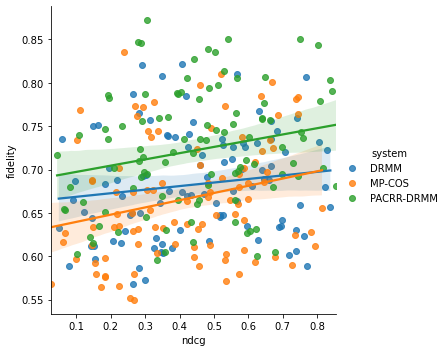

In [35]:
k = 3
bestworst = query_local_stats.copy()
bestworst['acc_rank'] = bestworst.sort_values('cv_accuracy_mean').rank().cv_accuracy_mean
extreme_queries = bestworst.sort_values('cv_accuracy_mean').groupby('system').take(np.r_[0:k,-k:0])['query'].unique()
bestworst = bestworst[bestworst['query'].isin(extreme_queries)]
bestworst = bestworst.reset_index()
bestworst = bestworst.pivot(index='query', columns='system')
bestworst['qstr'] = bestworst.index.map(topics.get)
bestworst = bestworst[['fidelity', 'qstr', 'ndcg']]
display(
bestworst.style.background_gradient(cmap='Greens_r', subset=['fidelity']).background_gradient(cmap='Blues_r', subset=['ndcg']).format('{:.2f}', subset=['fidelity', 'ndcg']),
sns.lmplot('ndcg', 'fidelity', query_local_stats, hue='system')
)

In [690]:
query_local_stats.groupby('system')[['ndcg', 'fidelity']].corr(method='spearman')

ndcg  fidelity
system                                 
DRMM       ndcg      1.000000  0.156905
           fidelity  0.156905  1.000000
MP-COS     ndcg      1.000000  0.264035
           fidelity  0.264035  1.000000
PACRR-DRMM ndcg      1.000000  0.202894
           fidelity  0.202894  1.000000

In [36]:
all_concordant_pairs.columns

Index(['ax_AND', 'ax_DIV', 'ax_LB1', 'ax_LNC1', 'ax_M_AND', 'ax_M_TDC',
       'ax_PROX1', 'ax_PROX2', 'ax_PROX3', 'ax_PROX4', 'ax_PROX5', 'ax_REG',
       'ax_STMC1', 'ax_STMC1_f', 'ax_STMC1_fr', 'ax_STMC2', 'ax_STMC2_f',
       'ax_STMC2_fr', 'ax_TFC1', 'ax_TFC3', 'ax_TF_LNC',
       'bm25_preference_opposite', 'concordant', 'id1', 'id1_pos_in_bm25',
       'id1_relevance', 'id1_score', 'id2', 'id2_pos_in_bm25', 'id2_relevance',
       'id2_score', 'qrel_preference', 'query', 'rankdiff', 'scorediff',
       'system', 'upper_rank', 'upper_score', 'qid', 'lower_rank',
       'lower_score'],
      dtype='object')

In [145]:
ranks = long.lower_rank.unique()
r = 1
long.query(f'lower_rank == {r} or upper_rank == {r}')

,id2_pos_in_bm25,query,lower_rank,system,id2_relevance,concordant,id1,upper_rank,upper_score,bm25_preference_opposite,...,id1_relevance,qid,id1_score,id2,scorediff,qrel_preference,id2_score,axiom,preference,abs_preference
1,13,425,0,PACRR-DRMM,1,1,FBIS3-54773,1,9.927786,False,...,1,425,0,LA102189-0077,0.372280,correct,0,ax_AND,0,0
21,5,425,0,DRMM,1,1,LA091590-0091,1,8.123950,False,...,1,425,0,FBIS4-47199,0.021278,correct,0,ax_AND,0,0
24,2,425,0,MP-COS,1,1,FBIS3-58171,1,4.209301,True,...,1,425,0,FBIS4-46741,0.020547,correct,0,ax_AND,0,0
30,15,425,1,DRMM,1,1,FBIS4-47199,8,7.974010,False,...,1,425,0,FT943-14585,0.149940,correct,0,ax_AND,0,0
31,23,425,1,DRMM,1,1,FBIS4-47199,5,8.037231,False,...,1,425,0,FBIS4-46047,0.086719,correct,0,ax_AND,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352,1,425,1,MP-COS,1,1,FBIS4-46741,4,3.847004,True,...,1,425,0,FBIS3-54773,0.362297,correct,0,ax_TF_LNC,0,0
3353,2,425,1,DRMM,1,1,FBIS4-47199,3,8.057719,True,...,1,425,0,FBIS4-46741,0.066231,correct,0,ax_TF_LNC,0,0
3354,26,425,1,PACRR-DRMM,1,1,LA102189-0077,9,8.806437,False,...,1,425,0,LA071389-0111,1.121349,correct,0,ax_TF_LNC,0,0
3355,11,425,1,PACRR-DRMM,1,1,LA102189-0077,10,8.618130,True,...,1,425,0,FBIS3-10532,1.309656,correct,0,ax_TF_LNC,0,0


In [430]:
def app(df):
    display(df.name)
tmp.groupby(['system', 'rank']).apply(app)

('DRMM', 0)

('DRMM', 1)

('DRMM', 2)

('DRMM', 3)

('DRMM', 4)

('DRMM', 5)

('DRMM', 6)

('DRMM', 7)

('DRMM', 8)

('DRMM', 9)

('DRMM', 10)

('PACRR-DRMM', 0)

('PACRR-DRMM', 1)

('PACRR-DRMM', 2)

('PACRR-DRMM', 3)

('PACRR-DRMM', 4)

('PACRR-DRMM', 5)

('PACRR-DRMM', 6)

('PACRR-DRMM', 7)

('PACRR-DRMM', 8)

('PACRR-DRMM', 9)

('PACRR-DRMM', 10)

('MP-COS', 0)

('MP-COS', 1)

('MP-COS', 2)

('MP-COS', 3)

('MP-COS', 4)

('MP-COS', 5)

('MP-COS', 6)

('MP-COS', 7)

('MP-COS', 8)

('MP-COS', 9)

('MP-COS', 10)

""


In [720]:

def axiom_evidence_strength(concordant_pairs, top_axioms=50):
    tmp = concordant_pairs
    long = tmp.sort_values('lower_rank').melt(
        value_vars=col_predictors, id_vars=set(tmp.columns).difference(col_predictors),
        var_name='axiom', value_name='preference')
    # long['abs_preference'] = long.preference.abs()
    # (long.groupby(['system', 'lower_rank', 'axiom'])[['preference', 'abs_preference']].sum()
    #  .reset_index().sort_values(['abs_preference', 'preference'], ascending=False)
    #  .groupby(['system', 'lower_rank']).head(top_axioms).groupby(['system', 'lower_rank'])
    #  .apply(lambda df: " ".join([f'{ax[3:]}:{pref}' for _, ax, pref in df[['axiom', 'preference']].itertuples()])))
    long = long[['system', 'lower_rank', 'upper_rank', 'axiom', 'preference']]
    tmp1 = long.copy()
    tmpcol = tmp1.lower_rank.copy()
    tmp1['lower_rank'] = tmp1.upper_rank
    tmp1['upper_rank'] = tmpcol
    tmp1.preference *= -1
    tmp = pd.concat([long, tmp1])
    tmp['pro'] = ((tmp.upper_rank > tmp.lower_rank) & (tmp.preference > 0)) | ((tmp.lower_rank > tmp.upper_rank) & (tmp.preference < 0))
    tmp['up'] = ((tmp.lower_rank > tmp.upper_rank) & (tmp.preference > 0))
    tmp['down'] = ((tmp.upper_rank > tmp.lower_rank) & (tmp.preference < 0))
    tmp['con'] = tmp.down | tmp.up
    tmp['abs_preference'] = tmp.preference.abs()
    # for each (lower_rank, upper_rank) pair, is there any pro/con from all axioms combined
    support = tmp[['system', 'lower_rank', 'upper_rank', 'pro', 'con']].groupby(['system', 'lower_rank', 'upper_rank']).sum()
    # for each lower_rank, wrt how many other ranks is this position supported/contested
    support_any = support.reset_index().groupby(['system', 'lower_rank']).agg(lambda x: (x>0).sum()).astype(int)
    # for each lower_rank, wrt to how many other ranks is there more pro than con across axioms
    support_maj = support.copy()
    support_maj['mpro'] = support_maj.pro > support_maj.con
    support_maj['mcon'] = support_maj.con > support_maj.pro
    support_maj = support_maj.reset_index().groupby(['system', 'lower_rank']).sum().astype(int)
    def axiom_sums(df):
        d = dict({'axiom': 'sum'})
        df = df.groupby('axiom')[['pro', 'con', 'up', 'down']].sum()
        def maprow(x):
            y = x.copy()
            y[:] = 0
            if x.pro > x.con:
                y.pro = 1
            elif x.up > x.down:
                y.up = 1
            elif x.down > x.up:
                y.down = 1
            return y
        d.update(df.apply(maprow, axis=1).sum().to_dict())
        return d
    tmp = tmp.groupby(
        ['system', 'lower_rank', 'axiom']
    )[['preference', 'abs_preference', 'pro', 'con', 'up', 'down']].sum().astype('int').reset_index().sort_values(
        ['pro', 'up', 'down'], ascending=False).groupby(
        ['system', 'lower_rank']).head(top_axioms).groupby(['system', 'lower_rank']).apply(
        lambda df: (
            [#{'axiom': 'any_pos', 'pro': support_any.loc[df.name]['pro'], 'con': support_any.loc[df.name]['con']},
             #{'axiom': 'maj_pos', 'pro': support_maj.loc[df.name]['mpro'], 'con': support_maj.loc[df.name]['mcon']},
             axiom_sums(df)
            ] +
            df[['axiom', 'pro', 'con', 'up', 'down']].query('pro>0 or con>0').to_dict(orient='records') )
    )
    tmp.index.names=['system', 'rank']
    tmp.name='support'
    return tmp


def format_evidence(evl, upto=50):
    out = []
    for e in evl[:upto]:
        ax = e["axiom"]
        if ax.startswith('ax_'):
            ax = r'\mathrm{' +  ax[3:].replace("_", "\\_") + '}'
        else:
            continue
        
        annote = f'^{{ \\textcolor{{green!40!black}}{{ {e["pro"]} }} }}_{{ \\textcolor{{red!75!black}} {{ {e["con"]} }} }}'
        out.append(f'${ax}{annote}$')
    return r"\quad ".join(out)


def format_evidence_sum(evl):
    s = [e for e in evl if e['axiom'] == 'sum'][0]
    sym = {'pro': r'\Leftrightarrow', 'up': r'\uparrow', 'down': r'\downarrow'}
    ph = r'\phantom{1}'
    return r'\quad '.join(f'${sym[k]}{ph if s[k]<10 else ""}{s[k]}$' for k in ['pro', 'up', 'down'])


# qid = 425
# tmp = all_concordant_pairs.query(f'qid == {qid} and upper_rank < 10 and lower_rank < 10')
# axiom_evidence_strength(tmp)

In [738]:
import quicklatex
import json
import re

def excerpt_text(txt):
    txt = re.sub(r"^Language:\s*[^\s]+\s*$", "", txt, flags=re.M)
    txt = re.sub(r"^Article Type:\s*[^\s]+\s*$", "", txt, flags=re.M)
    
    
    txt = re.sub(r"\s+", " ", txt)
    txt = re.sub(r"\[[^\]]*\]", "", txt)
    txt = re.sub(r"^\s*[A-Z]+:\s+", "", txt)
    txt = re.sub(r"^\w+ \(\w+\)\s*\W*\s*", "", txt)
    txt = re.sub(r"^([A-Z]{2,3}\s+|[0-9]{2,3}\s+)+\s*/\s*", "", txt)
    txt = re.sub(r"^.*DPA\W*", "", txt)
    txt = re.sub(r"^\s*(CSO|BFN)\s*", "", txt)
    txt = re.sub(r"^.{1,50}news agency", "", txt, flags=re.I)
    
    
    txt = re.sub(r"^[^0-9a-zA-Z]+", "", txt)
    return txt.capitalize().strip()

def fetch_something(docid):
    doc = fetch_doc(docid)
    title = excerpt_text(doc[0])
    text = excerpt_text(doc[1])
    if (not doc[0].startswith("NO_")) and len(title)>5:
        text = title + ' -- ' + text
    return text

def latex_table_topten(qid=425, system='MP-COS', mode='summary'):
    tmp = all_rankings.query(f'(qid == {qid}) and (rank < 10) and system != "BM25"').copy()
    evidence = axiom_evidence_strength(all_concordant_pairs.query(f'(qid == {qid}) and (lower_rank < 10) and (upper_rank < 10)'))

    tmp['Content'] = tmp.docid.map(lambda x: fetch_something(x))
    tmp = tmp.join(evidence)


    tmp1 = tmp.reset_index().rename(
        columns=lambda x: x.replace('_', ' ').capitalize()
    )
    tmp1['Relevance'] = tmp1.Relevance.fillna(-1000)
    tmp1['Docid'] = tmp1[['Docid', 'Relevance']].apply(
        lambda x: x[0] + (
            '' if x[1] == -1000
            else ('$^{' + ('+'*x[1] if x[1] else '-') + '}$')
        )
        , axis=1)
    #.drop(columns=['System', 'Docid', 'Relevance', 'Qid'])
    tmp1 = tmp1.query(f'System == "{system}"').head(10)[['Rank', 'Score', 'Docid', 'Content', 'Support']].rename(columns={'Support': 'Axioms'})
    tmp1.Rank += 1
    
    with pd.option_context('max_colwidth', -1):
        latex = tmp1.to_latex(
            index=False,
            escape=False,
            column_format='lrlll',
            formatters={
                'Axioms': format_evidence_sum if mode=='summary' else format_evidence,
                'Content': lambda x: x[:80].replace('_', ' ').replace('$', r'\$').replace('&', r'\&')+'\\dots',
                'Score': lambda x: '%.2f' % x
            }
        )
    
    insert = f"""\\small\\toprule
    \\multicolumn{{5}}{{@{{}}l@{{}}}}{{
    {{\\bfseries System:}}~{system}
    \qquad
    {{\\bfseries Query:}}~{qid}
    \quad
    ``{topics.get(qid)}''
    }}\\\\[.5ex]
    """
    
    latex = latex.replace(r"\toprule", insert)
    latex = re.sub(r'{tabular}{([^}]*)}', r'{tabular}{@{}\1@{}}', latex)
    
    tmp1['SAxioms']=tmp1.Axioms.map(lambda x: [(y['pro'], y['up'], y['down']) for y in x if y['axiom']=='sum'][0])
    tmp1['Axioms'] =tmp1.Axioms.map(lambda x: [(y['axiom'][3:], y['pro'], y['con']) for y in x if y['axiom'].startswith('ax_')])
    return tmp1, latex
    
qid=367
system='MP-COS'
mode='summary'
#mode='all'
df, tab = latex_table_topten(qid, system, mode=mode)
display(df)
#quicklatex.display(tab)
with open(f'tables/ranking-example-{qid}-{system.lower().replace("-", "_")}-{mode}.tex', 'w') as f:
    f.write(tab)

,Rank,Score,Docid,Content,Axioms,SAxioms
20,1,0.009488,FBIS4-11741$^{+}$,The american government said it is reviewing t...,"[(LNC1, 5, 1), (DIV, 1, 8), (STMC2, 1, 1), (ST...","(1, 0, 5)"
21,2,-0.026812,FBIS4-12458$^{+}$,As part of the israeli occupation authorities'...,"[(LNC1, 5, 1), (DIV, 1, 8), (REG, 0, 3), (STMC...","(1, 0, 5)"
22,3,-0.032025,FT942-4841$^{-}$,World trade news: dollars 200m vat loss from p...,"[(REG, 5, 3), (TFC1, 3, 0), (DIV, 2, 7), (LNC1...","(3, 0, 4)"
23,4,-0.036862,FBIS4-60230$^{-}$,Beirut--a lebanese military source announced t...,"[(LNC1, 5, 1), (DIV, 2, 7), (STMC2, 1, 1), (ST...","(1, 3, 2)"
24,5,-0.112558,FT932-2521$^{-}$,Technology (worth watching): breaking the copy...,"[(LNC1, 3, 3), (DIV, 1, 8), (STMC2, 1, 3), (ST...","(1, 0, 5)"
25,6,-0.207338,FT931-6602$^{+}$,No progress on malacca pirates -- Maritime exp...,"[(DIV, 5, 4), (LNC1, 2, 4), (STMC2, 1, 1), (ST...","(1, 4, 1)"
26,7,-0.331840,FT934-12634$^{-}$,Management (the growing business): avoiding th...,"[(DIV, 2, 7), (REG, 2, 6), (LNC1, 1, 0), (STMC...","(1, 2, 3)"
27,8,-0.341313,FBIS4-56772$^{-}$,"Havana, 9 may (pl) -- today, the cuban civil a...","[(LNC1, 4, 1), (STMC2, 2, 2), (STMC2_f, 2, 2),...","(3, 4, 0)"
28,9,-0.341313,FBIS4-68094$^{-}$,"Havana, 9 may (pl) -- the cuban civil aeronaut...","[(LNC1, 4, 1), (STMC2, 2, 1), (STMC2_f, 2, 1),...","(6, 1, 0)"
29,10,-0.424465,FT922-9038$^{-}$,Arts: violence on the high seas - nicholas woo...,"[(DIV, 0, 9), (REG, 0, 9)]","(0, 2, 0)"


RuntimeError: 500: Internal Server Error; b'<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n<html><head>\n<title>500 Internal Server Error</title>\n</head><body>\n<h1>Internal Server Error</h1>\n<p>The server encountered an internal error or\nmisconfiguration and was unable to complete\nyour request.</p>\n<p>Please contact the server administrator at \n webmaster@localhost to inform them of the time this error occurred,\n and the actions you performed just before this error.</p>\n<p>More information about this error may be available\nin the server error log.</p>\n<hr>\n<address>Apache/2.4.29 (Ubuntu) Server at quicklatex.com Port 80</address>\n</body></html>\n'

In [739]:
def write_table(qid, system, mode):
    df, tab = latex_table_topten(qid, system, mode=mode)
    with open(f'tables/ranking-example-{qid}-{system.lower().replace("-", "_")}-{mode}.tex', 'w') as f:
        f.write(tab)
from tqdm.notebook import tqdm
from itertools import product
tqdm
tables = tqdm(list(product(
     [425, 367, 336, 618],
     ['DRMM', 'PACRR-DRMM', 'MP-COS'],
     ['summary', 'all']
)))

for q,s,m in tables:
    tables.set_postfix(dict(query=q, system=s, mode=m))
    write_table(q, s, m)